# Image search

指定された画像と似ている画像を検索する。

pytorch:
* https://pytorch.org/

pytorchligtning:
* https://www.pytorchlightning.ai/

faiss:
* https://github.com/facebookresearch/faiss
* https://faiss.ai/

STL10:
* https://pytorch.org/vision/stable/datasets.html

AutoEndoder
* https://qiita.com/MuAuan/items/a062d0c245c8f4836399

## Setup for Notebook

In [1]:
# notebook runtime
import sys

runtime = 'local'
if 'google.colab' in sys.modules:
    runtime = 'colab'
elif _dh == ['/kaggle/working']:
    runtime = 'kaggle'
runtime

'colab'

In [2]:
if runtime == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
if runtime == 'colab':
    home_path = '/content/drive/MyDrive/image_similarity_search'
else:
    home_path = '/home/jovyan/image_similarity_search'

nbs_path = f'{home_path}/nbs'
datasets_path = f'{home_path}/datasets'
models_path = f'{home_path}/models'
figs_path = f'{home_path}/figs'

In [4]:
%cd {nbs_path}

/content/drive/MyDrive/image_similarity_search/nbs


In [5]:
!pip install -q pytorch_lightning

     |████████████████████████████████| 526 kB 5.0 MB/s 
     |████████████████████████████████| 332 kB 67.6 MB/s 
     |████████████████████████████████| 596 kB 66.2 MB/s 
     |████████████████████████████████| 829 kB 53.2 MB/s 
     |████████████████████████████████| 133 kB 69.9 MB/s 
     |████████████████████████████████| 1.1 MB 54.0 MB/s 
     |████████████████████████████████| 271 kB 74.4 MB/s 
     |████████████████████████████████| 160 kB 72.6 MB/s 
     |████████████████████████████████| 192 kB 71.1 MB/s 


In [6]:
!pip install -q faiss-gpu

     |████████████████████████████████| 85.5 MB 99 kB/s 


## Configuration

In [7]:
import os
import time
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import pickle
import shutil
from PIL import Image
import glob

In [8]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchsummary import summary

import torchvision
from torchvision import transforms

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

## Dataset

In [11]:
from torchvision.datasets import STL10

In [12]:
dataset_name = 'stl10'

In [13]:
def clear_datasets():
    path_cifar_10_batches_py = os.path.join(datasets_path, 'stl10_binary')
    if os.path.exists(path_cifar_10_batches_py):
        shutil.rmtree(path_cifar_10_batches_py)

    path_cifar_10_python = os.path.join(datasets_path, 'stl10_binary.tar.gz')
    if os.path.exists(path_cifar_10_python):
        os.remove(path_cifar_10_python)

In [14]:
#clear_datasets()

In [15]:
class DataModule(pl.LightningDataModule):

    def __init__(self, data_dir: str, batch_size: int=32):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = preprocess()
        self.classes = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
        self.num_classes = len(self.classes)
        self.dims = (3, 96, 96) # channels, width, height

    def prepare_data(self):
        # download
        STL10(self.data_dir, split='train', download=True)
        STL10(self.data_dir, split='test', download=True)

    def setup(self, stage=None): #train, val, testデータ分割
        # Assign train/val datasets for use in dataloaders
        datasets = STL10(self.data_dir, split='train', transform=self.transform)
        n_train = int(len(datasets) * 0.8)
        n_val = len(datasets) - n_train
        self.ds_train, self.ds_val = torch.utils.data.random_split(datasets, [n_train, n_val])
        self.ds_test = STL10(self.data_dir, split='test', transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.ds_train, shuffle=True, drop_last=True, batch_size=self.batch_size, num_workers=0)

    def val_dataloader(self):
        return DataLoader(self.ds_val, shuffle=False, batch_size=self.batch_size, num_workers=0)
 
    def test_dataloader(self):
        return DataLoader(self.ds_test, shuffle=False, batch_size=self.batch_size, num_workers=0)

In [17]:
def preprocess():
    return transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [18]:
datamodule = DataModule(datasets_path, 32)
datamodule.prepare_data()
datamodule.setup()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Files already downloaded and verified
Files already downloaded and verified


In [20]:
# check data size
train_dataloader = iter(datamodule.train_dataloader())
images, labels = next(train_dataloader)
images.shape, labels.shape

(torch.Size([32, 3, 96, 96]), torch.Size([32]))

## Training AutoEncoder

画像の特徴ベクトルを抽出するためAutoEncoder を学習する。

In [21]:
pl.seed_everything(42)

Global seed set to 42


42

In [29]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(512)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

In [30]:
encoder = Encoder()
encoder(torch.randn(32, 3, 96, 96)).shape

torch.Size([32, 512, 12, 12])

In [31]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 512, out_channels = 256,
                                 kernel_size = 2, stride = 2, padding = 0),
            nn.ConvTranspose2d(in_channels = 256, out_channels = 16,
                                 kernel_size = 2, stride = 2, padding = 0),
            nn.ConvTranspose2d(in_channels = 16, out_channels = 3,
                                 kernel_size = 2, stride = 2)
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

In [32]:
decoder = Decoder()
decoder(torch.randn(32, 512, 12, 12)).shape

torch.Size([32, 3, 96, 96])

In [33]:
class LitAutoEncoder(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, "val")

    def test_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, "test")
    
    def _common_step(self, batch, batch_idx, stage: str):
        x, y = batch
        loss = F.mse_loss(x, self(x))
        self.log(f"{stage}_loss", loss, on_step=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [34]:
# model
autoencoder = LitAutoEncoder()
autoencoder = autoencoder.to(device)  #for gpu
summary(autoencoder.encoder,(3, 96, 96))
summary(autoencoder.decoder,(512, 12, 12))
summary(autoencoder,(3, 96, 96))
print(autoencoder)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,792
              ReLU-2           [-1, 64, 96, 96]               0
         MaxPool2d-3           [-1, 64, 48, 48]               0
       BatchNorm2d-4           [-1, 64, 48, 48]             128
            Conv2d-5          [-1, 256, 48, 48]         147,712
              ReLU-6          [-1, 256, 48, 48]               0
         MaxPool2d-7          [-1, 256, 24, 24]               0
       BatchNorm2d-8          [-1, 256, 24, 24]             512
            Conv2d-9          [-1, 512, 24, 24]       1,180,160
             ReLU-10          [-1, 512, 24, 24]               0
        MaxPool2d-11          [-1, 512, 12, 12]               0
      BatchNorm2d-12          [-1, 512, 12, 12]           1,024
Total params: 1,331,328
Trainable params: 1,331,328
Non-trainable params: 0
---------------------------

In [35]:
path_encoder = f'{models_path}/{dataset_name}_autoencoder.ckpt'

In [36]:
def clear_autoencoder():
    if os.path.exists(path_encoder):
        os.remove(path_encoder)

In [37]:
clear_autoencoder()

In [38]:
if not os.path.exists(path_encoder):
    callbacks = [EarlyStopping(monitor="val_loss")]
    trainer = pl.Trainer(gpus=1, callbacks=callbacks)
    #trainer = pl.Trainer(max_epochs=10, gpus=1)
    trainer.fit(autoencoder, datamodule)
    trainer.save_checkpoint(path_encoder)
else:
    autoencoder = autoencoder.load_from_checkpoint(path_encoder)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 1.3 M 
1 | decoder | Decoder | 541 K 
------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.490     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [86]:
# functions to show an image
def imshow(img, file=None, title=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.figure(figsize=(8, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    if file:
        plt.savefig(file + '.png')
    plt.show()

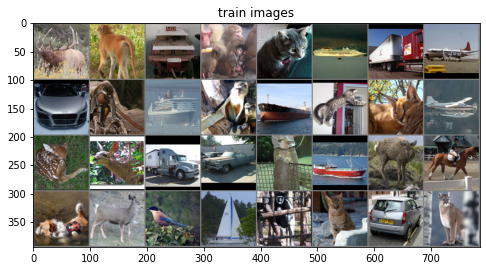

 deer monkey  ship monkey   cat  ship truck airplane


In [87]:
# Original train images
dataiter = iter(datamodule.train_dataloader())
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images), f'{figs_path}/{dataset_name}_train_original', title='train images')
print(' '.join('%5s' % datamodule.classes[labels[j]] for j in range(8)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


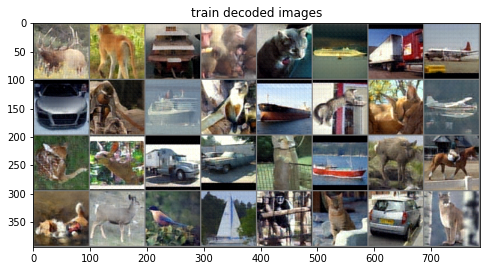

 deer monkey  ship monkey   cat  ship truck airplane


In [88]:
# Decoded train images
images_hat = autoencoder(images)
imshow(torchvision.utils.make_grid(images_hat), f'{figs_path}/{dataset_name}_train_decoded', title='train decoded images')
print(' '.join('%5s' % datamodule.classes[labels[j]] for j in range(8)))

In [42]:
autoencoder = autoencoder.to(device)  #for gpu
autoencoder.freeze()
autoencoder.eval()

LitAutoEncoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU()
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(2, 2

In [43]:
# Test
# 'test_loss': 0.003598422510549426
results = trainer.test(autoencoder, datamodule)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.013129102066159248, 'test_loss_epoch': 0.013129102066159248}
--------------------------------------------------------------------------------


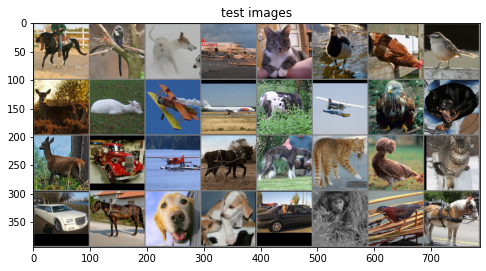

horse monkey   dog airplane   cat  bird  bird  bird


In [89]:
# Original test images
dataiter = iter(datamodule.test_dataloader())
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images), f'{figs_path}/{dataset_name}_test_original', title='test images')
print(' '.join('%5s' % datamodule.classes[labels[j]] for j in range(8)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


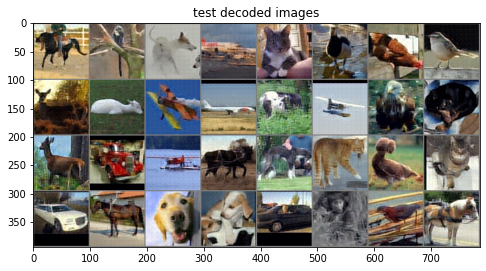

horse monkey   dog airplane   cat  bird  bird  bird


In [90]:
images_hat = autoencoder(images)
imshow(torchvision.utils.make_grid(images_hat), f'{figs_path}/{dataset_name}_test_decoded', title='test decoded images')
print(' '.join('%5s' % datamodule.classes[labels[j]] for j in range(8)))

## Embedding

検索対象画像と検索画像を特徴ベクトルへ変換する。

In [46]:
path_embeded_train = f'{models_path}/{dataset_name}_embeded_train.pickle'
path_embeded_test = f'{models_path}/{dataset_name}_embeded_test.pickle'

In [47]:
def clear_embedding():
    if os.path.exists(path_embeded_train):
        os.remove(path_embeded_train)
    if os.path.exists(path_embeded_test):
        os.remove(path_embeded_test)

In [48]:
clear_embedding()

In [49]:
train_dataset = STL10(datasets_path, split='train', download=True)
test_dataset = STL10(datasets_path, split='test', download=True)

Files already downloaded and verified
Files already downloaded and verified


In [50]:
len(train_dataset), len(test_dataset)

(5000, 8000)

In [51]:
# with preprocess
train_dataloader = DataLoader(STL10(datasets_path, split='train', download=True, transform=preprocess()),
                               shuffle=False, batch_size=32, num_workers=0)
test_dataloader = DataLoader(STL10(datasets_path, split='test', download=True, transform=preprocess()),
                               shuffle=False, batch_size=32, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [52]:
len(train_dataloader), len(test_dataloader)

(157, 250)

In [53]:
def create_embedder_model(autoencoder):
    layers = list(autoencoder.encoder.children())
    #fv = nn.Sequential(nn.AdaptiveMaxPool2d(output_size=1))
    fv = nn.Sequential(nn.Flatten(), nn.Linear(in_features=512*12*12, out_features=512))
    model = nn.Sequential(*layers, *fv)
    return model

In [54]:
embedder = create_embedder_model(autoencoder)
embedder

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=73728, out_features=512, bias=True)
)

In [55]:
img_random = torch.randn(32, 3, 96, 96)
img_emb = embedder(img_random)
img_emb.shape

torch.Size([32, 512])

In [56]:
def get_embeded_vector(embedder, dataloader):
    vector = []
    for i, (images, labels) in enumerate(tqdm(dataloader)):
        with torch.no_grad():
            v = embedder(images).squeeze().cpu()
        vector.extend(v.detach().numpy())

    return vector

In [57]:
if not os.path.exists(path_embeded_train):
    train_vectors = get_embeded_vector(embedder, train_dataloader)
    print(len(train_vectors), train_vectors[0].shape)
    with open(path_embeded_train, mode='wb') as f:
        pickle.dump(train_vectors, f)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/157 [00:00<?, ?it/s]

5000 (512,)


In [58]:
if not os.path.exists(path_embeded_test):
    test_vectors = get_embeded_vector(embedder, test_dataloader)
    print(len(test_vectors))
    with open(path_embeded_test, mode='wb') as f:
        pickle.dump(test_vectors, f)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/250 [00:00<?, ?it/s]

8000


## Faiss

検索用インデックスを生成する。

In [59]:
import faiss

In [60]:
path_indexer = f'{models_path}/{dataset_name}_indexer.faiss'

In [61]:
def clear_indexer():
    if os.path.exists(path_indexer):
        os.remove(path_indexer)

In [62]:
clear_indexer()

In [63]:
with open(path_embeded_train, mode='rb') as f:
    train_vectors = np.array(pickle.load(f))

train_vectors.shape

(5000, 512)

In [64]:
with open(path_embeded_test, mode='rb') as f:
    test_vectors = np.array(pickle.load(f))

test_vectors.shape

(8000, 512)

In [66]:
class FlatIndexer(object):

    def __init__(self, vector_sz: int, nlist=10, path=None):
        if path and os.path.exists(path):
            index_cpu = faiss.read_index(path)
            self.indexer = faiss.index_cpu_to_all_gpus(index_cpu)
        else:
            #index_cpu = faiss.IndexFlatIP(vector_sz) # Not Work
            quantizer = faiss.IndexFlatL2(vector_sz)
            index_cpu = faiss.IndexIVFFlat(quantizer, vector_sz, nlist, faiss.METRIC_L2)
            res = faiss.StandardGpuResources()
            self.indexer = faiss.index_cpu_to_gpu(res, 0, index_cpu)

    def index_data(self, vectors):
        self.indexer.train(vectors)
        self.indexer.add(vectors)

    def search_knn(self, query_vectors: np.array, top_docs: int):
        scores, indexes = self.indexer.search(query_vectors, top_docs)
        return scores, indexes

    def save_index(self, path):
        index_cpu = faiss.index_gpu_to_cpu(self.indexer)
        faiss.write_index(index_cpu, path)

In [67]:
if not os.path.exists(path_indexer):
    indexer = FlatIndexer(512)
    indexer.index_data(train_vectors)
    indexer.save_index(path_indexer)
else:
    indexer = FlatIndexer(512, path_indexer)

In [68]:
scores, indexes = indexer.search_knn(test_vectors, 10)

In [69]:
scores.shape, indexes.shape

((8000, 10), (8000, 10))

In [70]:
for i in range(0, 20):
    print(i, indexes[i])

0 [1362 2977 3807 1023  278  888 1159 1114 3645 3862]
1 [4802 4411  302 1509 2780  710 3034 3278  451 4622]
2 [3808 4957 4013 4180 2054  169 1449 1809 1221 4448]
3 [3418 2256 2257 3944 3655 1622 2263 2459 3050 1283]
4 [ 961 1121  832 4738 2399 4736 2485 1192 4506 1870]
5 [1121 1084 2370 2205 2240  839 3631 1082 4298  201]
6 [3965 1192 1121 4742  235 2814 4185 2485 2881 2448]
7 [1156  255 3839 3803 4061 2518 3797  505 1021 3646]
8 [2143  964 2704 1070 2093  323 2342 1069 2319 3339]
9 [3930 3743 3540 4733 1008 2706 4101 1245 3646  211]
10 [ 975 1025  711 2094 3682 4161 1922 1484 2614 3091]
11 [3837 3215 3223 4341 3056 4431  544   98 4411 2897]
12 [ 201 3678 2240 2961 1606 1830 2703  224 4738 4453]
13 [2155 3267   31 3986 4419  857 1638 4779 1221 1449]
14 [3871  723 3930 4661 3564 2359 1104 1952 3646 3991]
15 [1670 1453 1660 2441 1008 3803 2137 1630  505 1156]
16 [3488 4355 3871 3646 3540 3798 4770 3011 1008 3205]
17 [2004 2979 3290  827  160 1905 2175 4677 3006  630]
18 [1736 4013 1449  

In [71]:
scores[0]

array([233.466  , 242.02046, 256.37503, 259.82553, 267.8019 , 269.28775,
       269.79385, 272.04483, 272.1971 , 272.56567], dtype=float32)

In [72]:
def show_search_images(train_dataset, test_dataset, indexes, i):
    " train_dataset の中から test_dataset で指定された画像に似ている画像を検索する "
    fig, axes = plt.subplots(1, 11, figsize=(15,5))
    test_image, test_label = test_dataset[i]
    axes[0].imshow(test_image)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title(f'Q[{i}]')

    for col, idx in enumerate(indexes[i]):
        img, label = train_dataset[idx]
        axes[col+1].set_title(f'A[{idx}]')
        axes[col+1].imshow(img)
        axes[col+1].set_xticks([])
        axes[col+1].set_yticks([])
    plt.show()
    fig.savefig(f'{figs_path}/{dataset_name}_search_images_{i}')

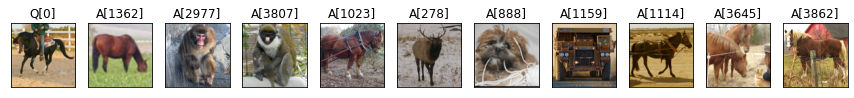

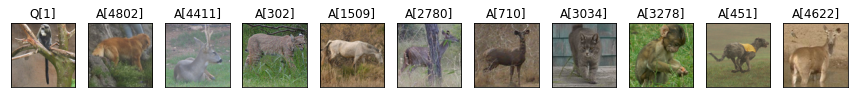

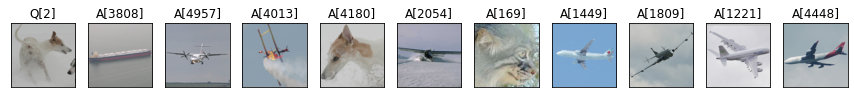

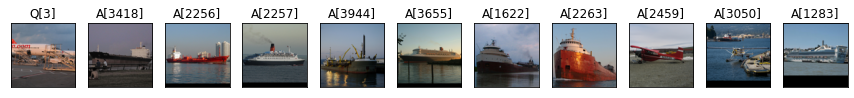

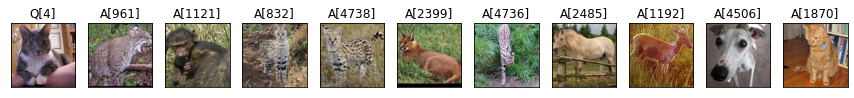

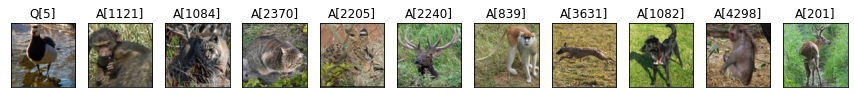

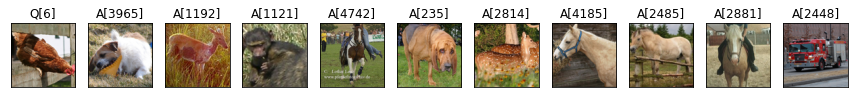

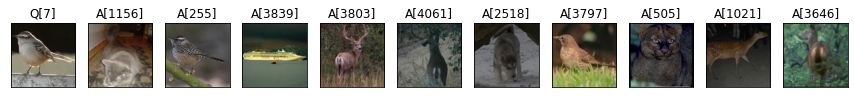

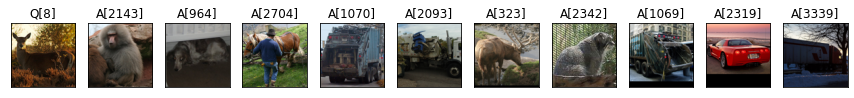

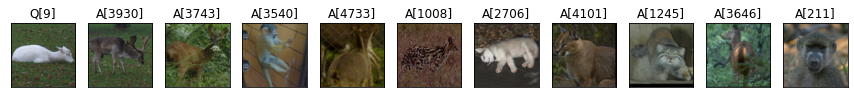

In [73]:
for i in range(10):
    show_search_images(train_dataset, test_dataset, indexes, i)

In [76]:
def merge_search_images(figs_path, dataset_name):
    files = glob.glob(f"{figs_path}/{dataset_name}_search_images_*.png")
    images = None
    for file in sorted(files):
        im = np.array(Image.open(file).convert('RGB'))
        h, w, c = im.shape
        im = im[120:h-130, 110:w-80, :] # trim
        if images is None:
            images = im
        else:
            images = np.append(images, im, axis=0)
    img = Image.fromarray(images)
    img.save(f"{figs_path}/{dataset_name}_search_images.png")
    return img

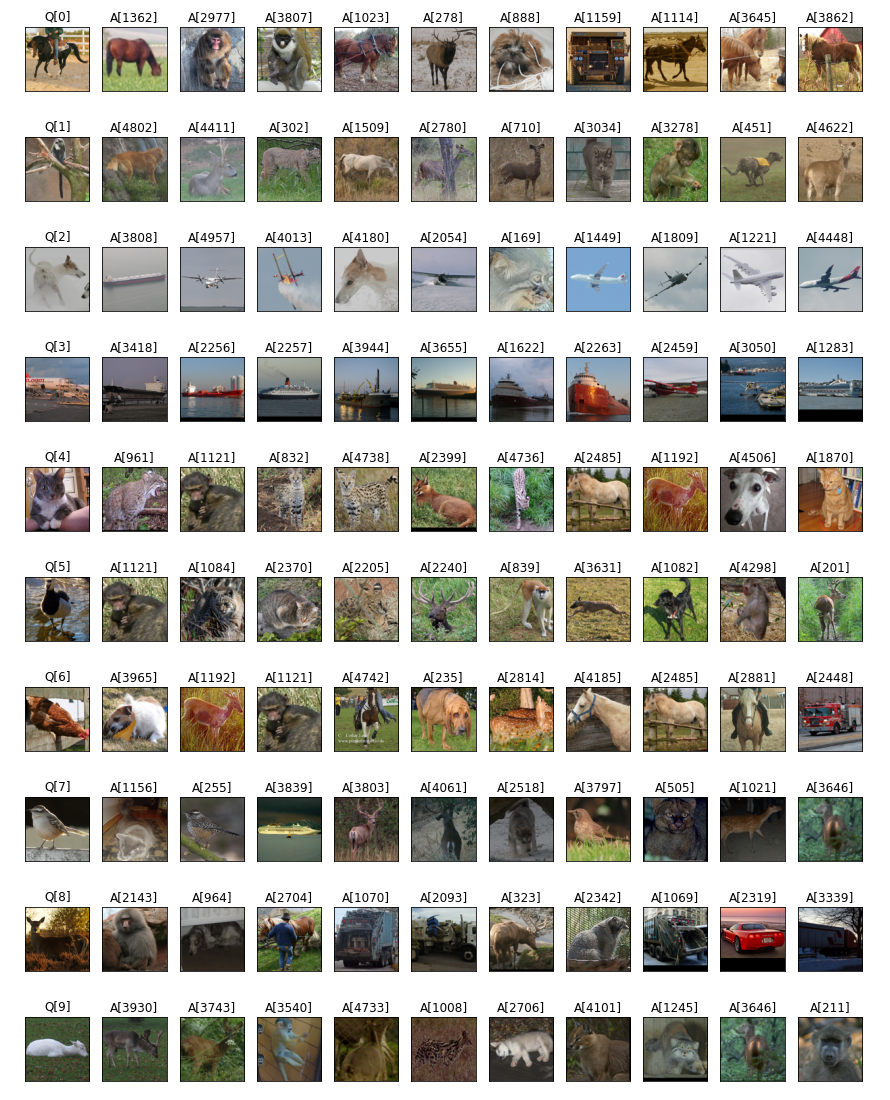

In [77]:
img = merge_search_images(figs_path, dataset_name)
img